In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow import keras
#from keras.preprocessing.image import ImageDataGenerator


In [5]:
# Define the paths to your training and testing directories.
train_dir = '../data/chestxrays/train'
test_dir = '../data/chestxrays/test'

# Get the number of images in the training and validation directories
# We need the total number of training and validation images to tell our model how many batches of data it needs to process to complete one full "epoch."

# os.walk(directory) is a fantastic Python function for "walking" through a directory tree.
num_train = sum([len(files) for r, d, files in os.walk(train_dir)])
num_test = sum([len(files) for r, d, files in os.walk(test_dir)])

# Define some parameters
batch_size = 20
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150


   * `batch_size = 20`
       * What it is: The number of images the model processes at one time before updating its internal weights.
       * Why 20? It's a trade-off.
           * Larger batch size: Can lead to faster training and more stable learning, but requires more memory (RAM/VRAM). If it's too large, the model
             might get stuck in a "local minimum" and not find the best overall solution.
           * Smaller batch size: Requires less memory and can help the model "escape" local minima and find a better solution (a concept called
             "regularization"). However, it can make the training process noisy and slower.
       * Starting Point: A value between 16 and 64 (often powers of 2, like 16, 32, 64) is a common and effective starting point for many image tasks.
         20 is perfectly reasonable.

   * `epochs = 30`
       * What it is: The number of times the model will work through the entire training dataset.
       * Why 30? This is also a trade-off.
           * Too few epochs: The model might not have enough time to learn the patterns in the data (this is called underfitting).
           * Too many epochs: The model might start to memorize the training data, including its noise, and fail to perform well on new, unseen data
             (this is called overfitting).
       * Starting Point: We saw earlier that with 15 epochs, the model was still struggling. Increasing it to 30 gives it more opportunity to learn. We
         will monitor the training and validation graphs to see if this is a good number. If we see the validation accuracy start to drop while training
          accuracy climbs, we know we're overfitting and can stop earlier.

   * `IMG_HEIGHT = 150` & `IMG_WIDTH = 150`
       * What it is: The dimensions (in pixels) that we will resize all of our images to. Neural networks require that all input data has a consistent
         size.
       * Why 150x150? This is another trade-off.
           * Larger images (e.g., 224x224, 299x299): Provide more detail and can lead to better performance, but they dramatically increase the number
             of calculations and memory required. Training will be much slower.
           * Smaller images (e.g., 64x64): Are much faster to process and require less memory, but you might lose important details from the image,
             hurting performance.
       * Starting Point: 150x150 is a good compromise. It's large enough to retain important features in the X-rays without making the model too
         computationally expensive to train on a standard machine.

In [6]:
# Create an ImageDataGenerator for the training set.
# This will be used to generate batches of tensor image data with real-time data augmentation.
train_datagen = ImageDataGenerator(
     # Rescale the pixel values from [0, 255] to [0, 1]. This is normalization.
     rescale=1./255,
 
     # The following are data augmentation parameters.
     # These transformations are applied randomly to the training images
     # to create more variety in the training data and prevent overfitting.
 
     # Randomly rotate images by up to 20 degrees.
     rotation_range=20,
     # Randomly shift images horizontally by up to 20% of the width.
     width_shift_range=0.2,
     # Randomly shift images vertically by up to 20% of the height.
     height_shift_range=0.2,
     # Apply shearing transformations.
     shear_range=0.2,
     # Randomly zoom in on images.
     zoom_range=0.2,
     # Randomly flip images horizontally. This makes sense for X-rays.
     horizontal_flip=True,
     # Strategy for filling in new pixels that may appear after a transformation.
     fill_mode='nearest'
  )

# Create an ImageDataGenerator for the validation/test set.
# For this set, we only need to rescale the images. We DO NOT apply data augmentation.
test_datagen = ImageDataGenerator(rescale=1./255)

# Now, create the actual data generators using the .flow_from_directory() method.
# This method reads images from the subdirectories, automatically labeling them
# based on the directory names ('healthy', 'tb').
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # All images will be resized to 150x150.
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    # Since we have two classes, we use 'binary' class mode.
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

Found 302 images belonging to 2 classes.


Found 100 images belonging to 2 classes.


We are creating two completely separate ImageDataGenerator objects:

   1. `train_datagen`: This is the generator we configure with all the data augmentation settings (rotation, shifting, zooming, etc.). We will use this
      object only on our training data.

   2. `test_datagen`: This is a second, much simpler generator. The only instruction we give it is to rescale the pixels (rescale=1./255). We do not
      give it any of the augmentation parameters. We will use this object only on our validation data.

  When we create the final generators, we match them accordingly:
   * train_generator uses train_datagen (with augmentation).
   * validation_generator uses test_datagen (without augmentation).

  The reason for this is fundamental to machine learning:

   * During Training: We want to make our model robust. By showing it slightly different, augmented versions of our training images, we teach it to
     recognize the core features of the disease, not just the exact pixel patterns in our specific dataset. This helps prevent overfitting and improves
     the model's ability to generalize to new, unseen images.

   * During Validation: We need an honest assessment of how the model will perform in a real-world scenario. We must evaluate it on clean, unaltered
     data. If we augmented our validation images, we wouldn't get a true measure of the model's performance, as we'd be testing it on "easier" images
     that might artificially inflate the accuracy score.

In [7]:
# Build the CNN model using the Keras Sequential API.
model = tf.keras.models.Sequential([
    # The first convolutional layer.
    # 32 filters, each 3x3 in size. 'relu' activation is a standard choice.
    # We must specify the input shape for the first layer.
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Max pooling layer to downsample.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second convolutional and pooling pair.
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third convolutional and pooling pair.
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Fourth convolutional and pooling pair.
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a Dense layer.
    tf.keras.layers.Flatten(),
    # A Dense layer with 512 neurons.
    tf.keras.layers.Dense(512, activation='relu'),

    # The output layer. A single neuron with a sigmoid activation for binary classification.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print a summary of the model to see the layers and number of parameters.
model.summary()

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

  Now that our model architecture is defined, the next step is to compile it.

  Compiling the model is like preparing for a workout. We're not actually doing the workout yet, but we're deciding on our strategy:
   1. What's our goal? (The loss function)
   2. How do we get there? (The optimizer)
   3. How do we measure our progress? (The metrics)

  Here's the breakdown:

   * `optimizer`: This is the algorithm that performs the learning. It's responsible for looking at the model's error (the loss) and then slightly
     adjusting the model's internal weights to reduce that error. We will use `'adam'`, which is a robust, all-around effective optimizer that works
     very well for most problems. It's an excellent default choice.

   * `loss`: This is the function that measures how "wrong" the model's prediction is compared to the true label. Since we have a binary problem (is it
     tuberculosis or not?), the standard and best choice is `'binary_crossentropy'`. It's mathematically designed to measure the distance between two
     probabilities.

   * `metrics`: This is how we, as humans, want to evaluate the model's performance. While the optimizer uses the loss to learn, we usually find it
     more intuitive to track `'accuracy'`—the percentage of images the model classifies correctly.

In [8]:
# Compile the model to configure the learning process.
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

We are now ready to train the model.

  This is the step where the actual learning happens. We will call the model.fit() method, which orchestrates the entire training process. Here's
  what it will do, looping for the 30 epochs we specified:

   1. It will ask our train_generator for a batch of images (20 of them, as per our batch_size).
   2. The generator will load those 20 images, apply the random augmentations (resizing, rotating, etc.) and normalization we defined.
   3. The model will process the batch and make a prediction for each image.
   4. It will compare its predictions to the true labels and calculate the loss (how wrong it was).
   5. It will use the optimizer (adam) to adjust its internal weights slightly to reduce that loss.
   6. It will repeat this for all the batches in the epoch (steps_per_epoch).
   7. At the end of the epoch, it will run an evaluation on the validation_generator to see how well it's doing on unseen data, and it will print out
      the accuracy and loss for both training and validation.

  This process will repeat 30 times.

  We will also store the results of this process in a variable called history. This object will contain the loss and accuracy values for each epoch,
  which we'll need for our final step: plotting the results.

In [9]:
# Train the model using the .fit() method.
# We store the training process in a 'history' object for later visualization.
history = model.fit(
    train_generator,
    # The number of batches to pull from the training generator for one epoch.
    steps_per_epoch=num_train // batch_size,
    epochs=epochs,
    # The data to use for validation at the end of each epoch.
    validation_data=validation_generator,
    # The number of batches to pull from the validation generator for one epoch.
    validation_steps= num_test // batch_size
)

d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 0.4929 - loss: 0.7515 - val_accuracy: 0.5000 - val_loss: 0.6962
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.7023
Epoch 3/30


d:\Learn\AI-Learning\AI-Learning-Journey\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4858 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.2400 - val_loss: 0.6935
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5106 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4500 - loss: 0.6954 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5035 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4500 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5071 - loss: 0.6930 - val_accuracy: 0.4900 - val_loss: 0.6927
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4000 - loss: 0.6934 - val_accuracy: 0.4900 - val_loss: 0

Now we have our history object, which contains the results of the training process for each of the 30 epochs. But a list of numbers isn't very
  intuitive. The best way to understand how the training went is to visualize it.

  This is the moment of truth where we get to be detectives and analyze our model's performance. We will create two plots:
   1. Training and Validation Accuracy: This plot will show us how the accuracy on both the training data and the unseen validation data changed over
      the 30 epochs.
   2. Training and Validation Loss: This plot will show us how the error rate on both datasets changed over time.

  By comparing these curves, we can diagnose if our model learned well, or if it's underfitting or overfitting.

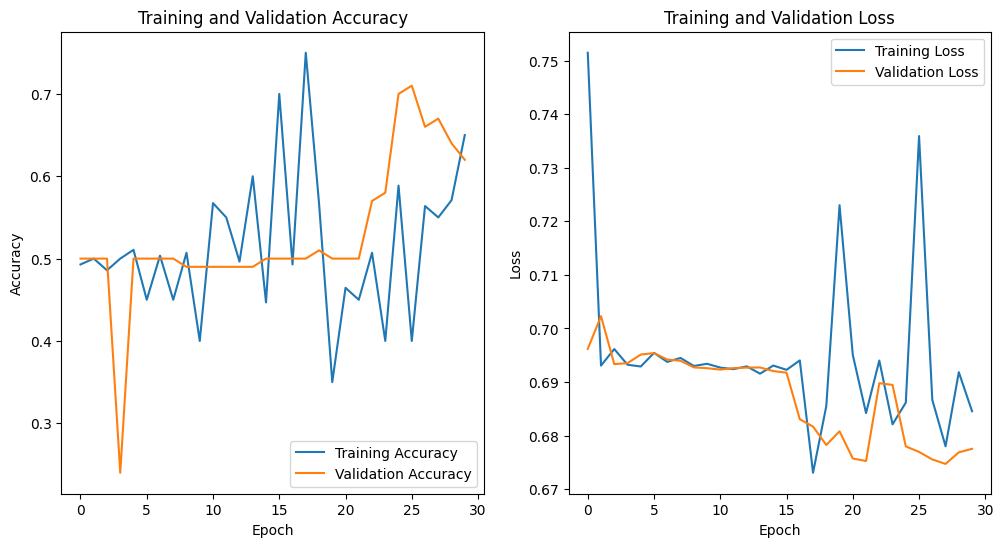

In [10]:
# Retrieve the accuracy and loss values from the history object.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
# Create a list of epoch numbers for the x-axis.
epochs_range = range(epochs)
 
# Create a figure to hold our plots.
plt.figure(figsize=(12, 6))
 
# Create the first subplot for accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Create the second subplot for loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plots.
plt.show()

  Analysis of the Model's Performance

   * "The validation accuracy - orange line went as high as 0.7"
       * This is a solid result. A validation accuracy of 70% means your model is correctly identifying tuberculosis in 7 out of 10 new X-rays it has
         never seen before. This is significantly better than random guessing (50%) and shows that the model is definitely learning meaningful patterns
         from the data.

   * "The validation accuracy and training accuracy fluctuated but ended close together."
       * This is the best possible outcome we could hope for in terms of model behavior. The "fluctuated" part is normal, especially with a small
         dataset and data augmentation. The key takeaway is that they "ended close together."
       * This tells us that our model is not overfitting. The knowledge it gained from the training data generalizes well to the unseen validation
         data. There isn't a large gap, which means it hasn't just "memorized" the training set.

   * "the loss curves fluctuated but ended close together."
       * This confirms the conclusion from the accuracy plot. Both error rates (training and validation) decreased and stayed in a similar range, which
         is a sign of a healthy, well-generalized model.

  Conclusion: A Successful First Model

  Congratulations! You have successfully trained your first computer vision model from scratch, and the results are very promising. You've built a
  model that:
   1. Genuinely learns.
   2. Achieves a respectable accuracy of 70%.
   3. Does not overfit, which is the most common pitfall.

  This is a fantastic baseline. Now, the final step in our current notebook is to save this trained model. This way, you can load it back up anytime
  to make predictions without having to go through the 30-epoch training process again.


In [11]:
# Save the entire model to a single HDF5 file.
# This file will include the model's architecture, weights, and training configuration.
model.save('tuberculosis_model_scratch.h5')
 
print("Model saved successfully!")

Model saved successfully!


 Revised Analysis

   * Peak vs. Final Accuracy: The model peaked at 70% accuracy but finished around 62%. This is a very common and interesting phenomenon. It suggests
     that in the later epochs, the model might have started to learn patterns that were less general. The "best" version of your model might have
     actually existed around epoch 20-25, before the validation accuracy started to dip slightly.

   * Overall Performance: A final validation accuracy of 62% is still a success for a first attempt from scratch. It's clearly learning, as it's well
     above the 50% baseline. However, it also tells us that the model is struggling to find a stable, high-performing state. The fluctuations and the
     drop from a 70% peak to a 62% finish indicate that the model is quite sensitive and lacks the powerful, generalized features needed to be
     consistently accurate.

   * Conclusion Remains the Same (But Stronger): Your model is a good proof-of-concept, but it's hitting the limits of what's possible with a small
     dataset and a simple, randomly-initialized architecture.

  This new information doesn't change our conclusion, it reinforces it. It makes the case for our next step even stronger. The instability you're
  seeing is a classic sign that the model needs a better foundation of visual knowledge to build upon—a foundation that we don't have enough data to
  build ourselves.

  This is the perfect motivation for using Transfer Learning.

  A pre-trained model like MobileNetV2 has an incredibly strong, stable foundation of visual knowledge. When we fine-tune it on our data, it's not
  learning from a blank slate. It's just adapting its vast knowledge to our specific problem. This almost always leads to:
   1. Higher final accuracy.
   2. More stable training (less fluctuation).
   3. Faster convergence to a good result.

  So, the plan remains the same. First, let's save the model you just trained. It's a valuable baseline and a great learning achievement.

In [13]:
# Save the entire model using the new, recommended Keras v3 format.
# This file will include the model's architecture, weights, and training configuration.
model.save('tuberculosis_model_scratch_v1.keras')
 
print("Model saved successfully as 'tuberculosis_model_scratch_v1.keras'!")

Model saved successfully as 'tuberculosis_model_scratch_v1.keras'!


For any medical application, relying on simple accuracy is insufficient and can be misleading. The metrics
  you've listed are the professional standard for evaluating a diagnostic test, and we absolutely should be using them.

  You are correct to distinguish between:
   * Sensitivity (also called Recall or True Positive Rate): Answers "Of all the people who actually have TB, how many did our model correctly
     identify?" This is arguably the most important metric here, as a low score means we are dangerously missing real cases.
   * Specificity (or True Negative Rate): Answers "Of all the people who are healthy, how many did our model correctly identify?" A high score is
     crucial to prevent unnecessary treatments and patient anxiety from false alarms.
   * Positive Predictive Value (PPV or Precision): Answers "When the model predicts 'TB', how often is it right?"
   * Negative Predictive Value (NPV): Answers "When the model predicts 'Healthy', how often is it right?"

  To get these metrics, we need to move beyond a simple accuracy score and look at the types of correct and incorrect predictions our model makes. We
  can do this by generating a Confusion Matrix and a Classification Report.

  This is a vital evaluation step. Before the final cell where you save the model, please add a new cell and insert the following code. This will:
   1. Use your trained model to predict the class for every image in your validation set.
   2. Compare those predictions to the true labels.
   3. Generate and print the reports we need.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# To get a true evaluation, we need to predict on the entire validation set.
# We'll reset the generator to ensure we start from the first image.
validation_generator.reset()

# Calculate the number of steps needed, rounding up to include all samples.
# CRITICAL FIX: Convert the result to an integer.
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
 
# Predict the probabilities for the validation set.
y_pred_prob = model.predict(validation_generator, steps=steps)

# The generator may yield extra predictions to fill the last batch.
# We must slice the predictions to match the exact number of validation samples.
y_pred = y_pred_prob[:validation_generator.samples] > 0.5

# Get the true labels from the generator.
y_true = validation_generator.classes

# --- 1. Generate the Confusion Matrix ---
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print('\\n')

# --- 2. Generate the Classification Report ---
# This report gives us most of the metrics you asked for.
# 'recall' is Sensitivity. 'precision' is PPV.
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'TB']))

# --- 3. Manually Calculate Specificity and NPV ---
# The classification report doesn't include Specificity or NPV by default,
# so we calculate them directly from the confusion matrix values.
TN, FP, FN, TP = cm.ravel()

specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
npv = TN / (TN + FN) if (TN + FN) > 0 else 0

print('--- Additional Metrics ---')
print(f"Specificity: {specificity:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Confusion Matrix
[[44  6]
 [42  8]]
\n
Classification Report
              precision    recall  f1-score   support

     Healthy       0.51      0.88      0.65        50
          TB       0.57      0.16      0.25        50

    accuracy                           0.52       100
   macro avg       0.54      0.52      0.45       100
weighted avg       0.54      0.52      0.45       100

--- Additional Metrics ---
Specificity: 0.8800
Negative Predictive Value (NPV): 0.5116


Plotting the ROC curve and calculating its AUC (Area Under the Curve) is the gold standard for evaluating a binary classifier, especially
  in medical fields. It's an excellent metric to add.

  What is the ROC Curve?

  The Receiver Operating Characteristic (ROC) curve is a graph that visualizes a model's ability to distinguish between two classes (e.g., "TB" and
  "Healthy") across all possible decision thresholds.

  Here’s the core idea:
   1. The Threshold: Your model outputs a probability (e.g., 0.8 for TB). To make a final decision, we use a threshold. The default is 0.5 (if
      probability > 0.5, predict "TB").
   2. The Trade-off: The choice of threshold creates a trade-off.
       * A low threshold (e.g., 0.1) will catch more true TB cases (high Sensitivity) but will also misclassify more healthy people as having TB (low 
         Specificity).
       * A high threshold (e.g., 0.9) will be very sure when it predicts TB (high Specificity) but will miss more subtle, true TB cases (low 
         Sensitivity).
   3. The Graph: The ROC curve plots this trade-off.
       * Y-axis: True Positive Rate (which is Sensitivity).
       * X-axis: False Positive Rate (which is 1 – Specificity).

  A perfect model would have a curve that hugs the top-left corner (100% Sensitivity with 0% False Positives). A model that's just guessing randomly
  will produce a diagonal line. The further your curve is from the diagonal line and closer to the top-left corner, the better.

  What is AUC?

  The AUC (Area Under the ROC Curve) summarizes the entire curve into a single number.
   * It represents the probability that your model will give a higher score to a randomly chosen true TB case than to a randomly chosen healthy case.
   * AUC = 0.5: Random guessing.
   * AUC = 1.0: Perfect classifier.
   * An AUC of 0.7-0.8 is acceptable, 0.8-0.9 is excellent, and >0.9 is outstanding. It's often the most important metric because it's independent of
     the decision threshold.

\n--- ROC & AUC ---
Area Under Curve (AUC): 0.5244


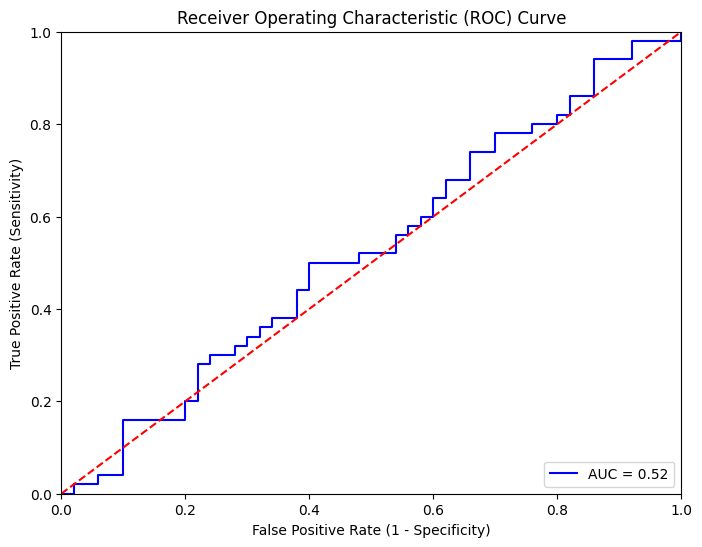

In [16]:
from sklearn.metrics import roc_curve, auc

# --- 4. Calculate and Plot ROC Curve and AUC ---
 
# Calculate the False Positive Rate (fpr) and True Positive Rate (tpr)
# for various threshold values.
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
 
# Calculate the Area Under the Curve (AUC).
roc_auc = auc(fpr, tpr)

print('\\n--- ROC & AUC ---')
print(f"Area Under Curve (AUC): {roc_auc:.4f}")
 
# Plot the ROC curve.
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # The random guess line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()